Идея самостоятельно реализовать GAN появилась после прохождения курса Build Basic Generative Adversarial Networks (GANs) от deeplearning.ai. Цель: посмотреть как изменеие параметров сетей (генератора и дискриминатора) повлияют на обучение.

Какой можно сделать вывод:
1.   Дискриминатор не должен быть слишком хорош (все так, как говорили на курсах)
2.   ConvTransponse2d не уступает связке Upslample + Conv2d (в этом конкретном случае точно)
3.   На последних эпохах обучения Дискриминатор научился точно отличать фэйковые изображения от настоящих, поэтому обратная саязь Генератору не поступала, в следствие чего он перестал учиться.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from copy import deepcopy
from torchvision.utils import make_grid
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])

batch_size = 128
trainset = torchvision.datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_size=512):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.create_block(10,256,ks=4,st=1,p=0),       #1,1-> 4,4
            self.create_block(256,128,ks=4,st=2,p=1),       #4,4-> 8,8
            self.create_block(128,128,ks=4,st=2,p=1),        #8,8-> 16,16
            self.create_block(128,64,ks=2,st=2,p=1),         #16,16-> 30,30
            #self.create_block(64,32,ks=3,st=1,p=1),        # 30,30 ->30,30
            self.create_block(64,1,ks=3,last = True)        #30,30-> 28,28    
        )
    
    def create_block(self,in_c:int,out_c:int,ks=4,p=1, st=1, last=False):
        if last:
            layer = nn.Sequential(
                nn.Conv2d(in_channels=in_c,out_channels=1,kernel_size=ks,
                          stride=st),
                nn.Tanh()
            )
            return layer
        layer = nn.Sequential(
          nn.ConvTranspose2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,
                          stride=st,padding = p),
          nn.BatchNorm2d(out_c),
          nn.ReLU()
        )
        return layer
    def forward(self,x):
      return self.net(x)

    def _check(self):
      noise = torch.rand((32,10,1,1),dtype=torch.float32)
      out = self.forward(noise)
      #print(out.shape)
      assert out.shape == torch.Size([32,1,28,28])

Gen = Generator()
Gen._check()
      

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,out_size=1):
        self.out_neuron = out_size
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            self.create_block(1,16),  # bs,16,13,13
            self.create_block(16,32), # bs,32,5,5
            self.create_block(32,1,last=True)

        )

    def create_block(self,in_c:int, out_c:int, ks=4, p=0, st=2, last=False):
        if last:
            layer = nn.Sequential(
                nn.Conv2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,
                          padding = p, stride=st),
                          nn.Flatten()
            )
            return layer
        layer = nn.Sequential(
            nn.Conv2d(in_channels=in_c,out_channels=out_c,kernel_size=ks,stride=st, padding=p),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
        return layer

    def forward(self,x):
        x = self.net(x)
        return x
    
    def _check(self):
        x = torch.rand((32,1,28,28))
        out = self.forward(x)
        assert out.shape == torch.Size([32,1])

Dis = Discriminator(1)
Dis._check()   

In [ ]:
Gen = Gen.to(device)
Dis = Dis.to(device)

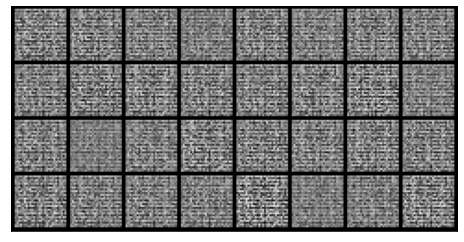

In [ ]:
def denorm(img_tensors,mean=0.5,std=0.5):
    return img_tensors * std + mean
    
def show_images(images, nmax=32):
    images = images.cpu()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach())[:nmax], nrow=8).permute(1, 2, 0))
    plt.show()
noise_vector = torch.rand((128,10,1,1),dtype=torch.float32,device=device)
fake_image = Gen(noise_vector)
show_images(fake_image)

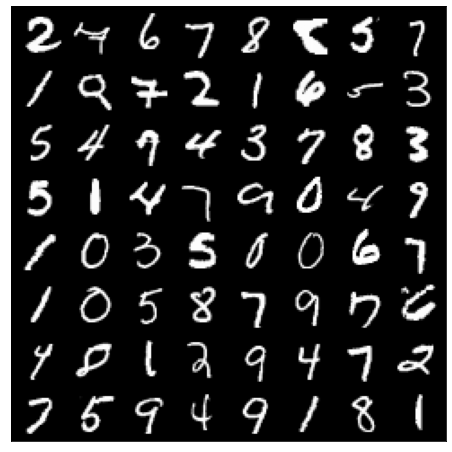

In [ ]:
for image, _ in trainloader:
    show_images(image, nmax = 64)
    break

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
#show_tensor_images(fake_image)

In [ ]:
def get_noise(bs=batch_size,latent_size = 10):
    return torch.rand((bs,latent_size,1,1),dtype=torch.float32,device=device)
assert get_noise().shape[0] == batch_size

  1%|          | 1/100 [00:16<26:43, 16.19s/it]


Epoch [1/100], loss_g: 1.0870, loss_d: 4.5344


  2%|▏         | 2/100 [00:32<26:25, 16.18s/it]


Epoch [2/100], loss_g: 2.5246, loss_d: 2.6202


  3%|▎         | 3/100 [00:48<26:17, 16.27s/it]


Epoch [3/100], loss_g: 2.5651, loss_d: 2.5940


  4%|▍         | 4/100 [01:05<26:12, 16.38s/it]


Epoch [4/100], loss_g: 2.5787, loss_d: 2.5985

Epoch [5/100], loss_g: 2.6064, loss_d: 2.5892


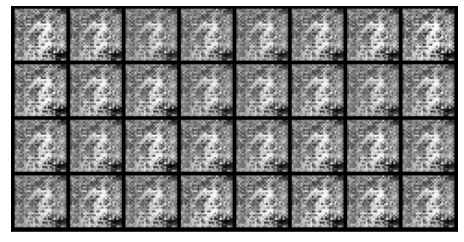

  6%|▌         | 6/100 [01:38<25:58, 16.58s/it]


Epoch [6/100], loss_g: 2.6160, loss_d: 2.5836


  7%|▋         | 7/100 [01:55<25:52, 16.69s/it]


Epoch [7/100], loss_g: 2.6245, loss_d: 2.5853


  8%|▊         | 8/100 [02:12<25:40, 16.75s/it]


Epoch [8/100], loss_g: 2.6238, loss_d: 2.5802


  9%|▉         | 9/100 [02:29<25:32, 16.84s/it]


Epoch [9/100], loss_g: 2.6047, loss_d: 2.5734

Epoch [10/100], loss_g: 2.6219, loss_d: 2.5642


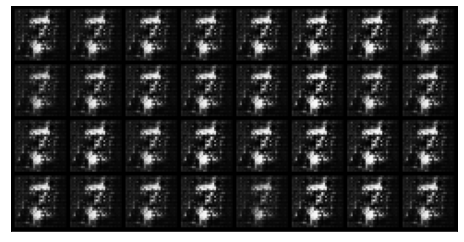

 11%|█         | 11/100 [03:03<25:12, 16.99s/it]


Epoch [11/100], loss_g: 2.6048, loss_d: 2.5757


 12%|█▏        | 12/100 [03:20<24:57, 17.01s/it]


Epoch [12/100], loss_g: 2.6526, loss_d: 2.5569


 13%|█▎        | 13/100 [03:37<24:40, 17.02s/it]


Epoch [13/100], loss_g: 2.6719, loss_d: 2.5442


 14%|█▍        | 14/100 [03:54<24:22, 17.01s/it]


Epoch [14/100], loss_g: 2.7697, loss_d: 2.4984

Epoch [15/100], loss_g: 2.7925, loss_d: 2.5053


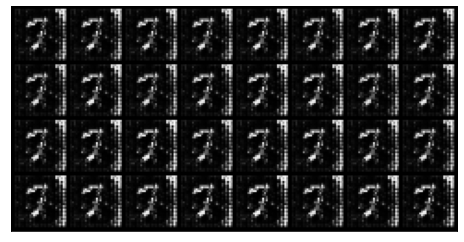

 16%|█▌        | 16/100 [04:29<23:51, 17.04s/it]


Epoch [16/100], loss_g: 2.8881, loss_d: 2.4439


 17%|█▋        | 17/100 [04:46<23:35, 17.06s/it]


Epoch [17/100], loss_g: 3.0144, loss_d: 2.4282


 18%|█▊        | 18/100 [05:03<23:20, 17.08s/it]


Epoch [18/100], loss_g: 3.0597, loss_d: 2.3995


 19%|█▉        | 19/100 [05:20<23:03, 17.08s/it]


Epoch [19/100], loss_g: 3.0715, loss_d: 2.4088

Epoch [20/100], loss_g: 3.0803, loss_d: 2.3813


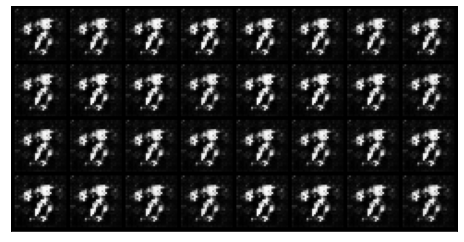

 21%|██        | 21/100 [05:54<22:28, 17.07s/it]


Epoch [21/100], loss_g: 3.1335, loss_d: 2.3669


 22%|██▏       | 22/100 [06:11<22:11, 17.07s/it]


Epoch [22/100], loss_g: 3.2260, loss_d: 2.3220


 23%|██▎       | 23/100 [06:28<21:54, 17.07s/it]


Epoch [23/100], loss_g: 3.6256, loss_d: 2.1090


 24%|██▍       | 24/100 [06:45<21:35, 17.05s/it]


Epoch [24/100], loss_g: 3.5448, loss_d: 2.1782

Epoch [25/100], loss_g: 3.5744, loss_d: 2.1467


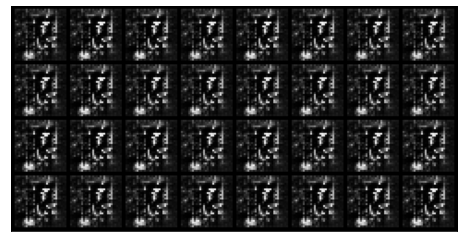

 26%|██▌       | 26/100 [07:19<21:04, 17.08s/it]


Epoch [26/100], loss_g: 3.6312, loss_d: 2.1345


 27%|██▋       | 27/100 [07:36<20:46, 17.08s/it]


Epoch [27/100], loss_g: 3.8526, loss_d: 1.9341


 28%|██▊       | 28/100 [07:54<20:28, 17.06s/it]


Epoch [28/100], loss_g: 4.7351, loss_d: 1.6783


 29%|██▉       | 29/100 [08:11<20:10, 17.05s/it]


Epoch [29/100], loss_g: 4.2080, loss_d: 1.9995

Epoch [30/100], loss_g: 4.0328, loss_d: 2.0544


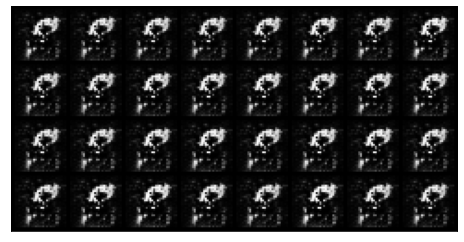

 31%|███       | 31/100 [08:45<19:39, 17.09s/it]


Epoch [31/100], loss_g: 4.3598, loss_d: 1.8323


 32%|███▏      | 32/100 [09:02<19:22, 17.09s/it]


Epoch [32/100], loss_g: 4.3521, loss_d: 1.9413


 33%|███▎      | 33/100 [09:19<19:03, 17.07s/it]


Epoch [33/100], loss_g: 4.2800, loss_d: 1.9878


 34%|███▍      | 34/100 [09:36<18:46, 17.07s/it]


Epoch [34/100], loss_g: 4.3963, loss_d: 1.8978

Epoch [35/100], loss_g: 5.6237, loss_d: 1.2160


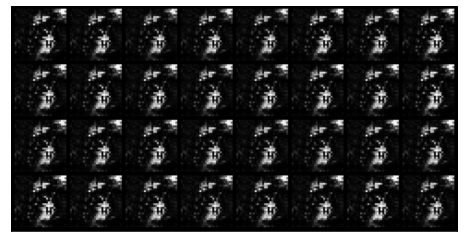

 36%|███▌      | 36/100 [10:10<18:13, 17.08s/it]


Epoch [36/100], loss_g: 4.8961, loss_d: 1.7986


 37%|███▋      | 37/100 [10:27<17:55, 17.07s/it]


Epoch [37/100], loss_g: 4.9614, loss_d: 1.6904


 38%|███▊      | 38/100 [10:44<17:38, 17.08s/it]


Epoch [38/100], loss_g: 5.2293, loss_d: 1.5720


 39%|███▉      | 39/100 [11:01<17:23, 17.11s/it]


Epoch [39/100], loss_g: 5.7890, loss_d: 1.3857

Epoch [40/100], loss_g: 5.8510, loss_d: 1.4337


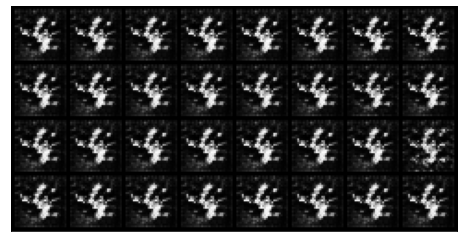

 41%|████      | 41/100 [11:36<16:50, 17.13s/it]


Epoch [41/100], loss_g: 5.9523, loss_d: 1.3871


 42%|████▏     | 42/100 [11:53<16:32, 17.11s/it]


Epoch [42/100], loss_g: 8.7787, loss_d: 0.5957


 43%|████▎     | 43/100 [12:10<16:14, 17.09s/it]


Epoch [43/100], loss_g: 11.5223, loss_d: 0.3337


 44%|████▍     | 44/100 [12:27<15:55, 17.07s/it]


Epoch [44/100], loss_g: 13.4072, loss_d: 0.1660

Epoch [45/100], loss_g: 11.2892, loss_d: 0.3900


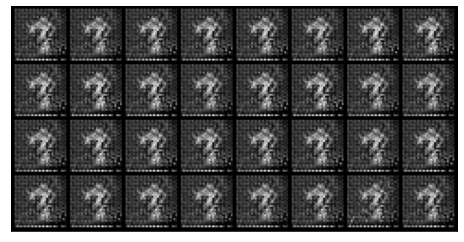

 46%|████▌     | 46/100 [13:01<15:22, 17.09s/it]


Epoch [46/100], loss_g: 7.8363, loss_d: 0.9646


 47%|████▋     | 47/100 [13:18<15:06, 17.10s/it]


Epoch [47/100], loss_g: 9.2916, loss_d: 0.5793


 48%|████▊     | 48/100 [13:35<14:49, 17.10s/it]


Epoch [48/100], loss_g: 8.7929, loss_d: 0.7815


 49%|████▉     | 49/100 [13:52<14:30, 17.07s/it]


Epoch [49/100], loss_g: 8.6821, loss_d: 0.7807

Epoch [50/100], loss_g: 9.1275, loss_d: 0.7645


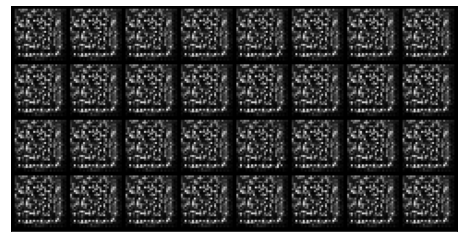

 51%|█████     | 51/100 [14:27<13:57, 17.09s/it]


Epoch [51/100], loss_g: 14.7212, loss_d: 0.1928


 52%|█████▏    | 52/100 [14:44<13:40, 17.09s/it]


Epoch [52/100], loss_g: 14.6999, loss_d: 0.1925


 53%|█████▎    | 53/100 [15:01<13:22, 17.08s/it]


Epoch [53/100], loss_g: 14.8573, loss_d: 0.2613


 54%|█████▍    | 54/100 [15:18<13:04, 17.05s/it]


Epoch [54/100], loss_g: 10.5710, loss_d: 0.5528

Epoch [55/100], loss_g: 10.1225, loss_d: 0.5692


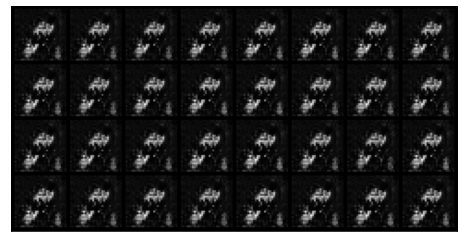

 56%|█████▌    | 56/100 [15:52<12:32, 17.11s/it]


Epoch [56/100], loss_g: 10.4321, loss_d: 0.5281


 57%|█████▋    | 57/100 [16:09<12:16, 17.13s/it]


Epoch [57/100], loss_g: 10.8060, loss_d: 0.5492


 58%|█████▊    | 58/100 [16:26<12:00, 17.15s/it]


Epoch [58/100], loss_g: 10.2621, loss_d: 0.6511


 59%|█████▉    | 59/100 [16:44<11:42, 17.15s/it]


Epoch [59/100], loss_g: 12.4408, loss_d: 0.4352

Epoch [60/100], loss_g: 16.9882, loss_d: 0.1418


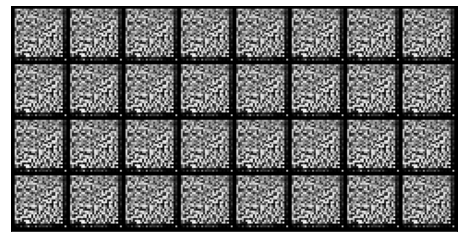

 61%|██████    | 61/100 [17:18<11:09, 17.17s/it]


Epoch [61/100], loss_g: 19.8083, loss_d: 0.0856


 62%|██████▏   | 62/100 [17:35<10:51, 17.14s/it]


Epoch [62/100], loss_g: 20.3193, loss_d: 0.0662


 63%|██████▎   | 63/100 [17:52<10:32, 17.10s/it]


Epoch [63/100], loss_g: 20.4230, loss_d: 0.0699


 64%|██████▍   | 64/100 [18:09<10:14, 17.07s/it]


Epoch [64/100], loss_g: 20.5086, loss_d: 0.0574

Epoch [65/100], loss_g: 22.4125, loss_d: 0.0529


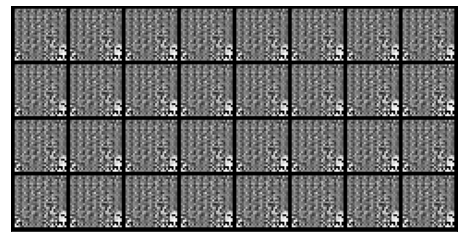

 66%|██████▌   | 66/100 [18:43<09:42, 17.12s/it]


Epoch [66/100], loss_g: 24.2327, loss_d: 0.0288


 67%|██████▋   | 67/100 [19:00<09:24, 17.09s/it]


Epoch [67/100], loss_g: 25.0642, loss_d: 0.0157


 68%|██████▊   | 68/100 [19:17<09:05, 17.04s/it]


Epoch [68/100], loss_g: 28.5038, loss_d: 0.0129


 69%|██████▉   | 69/100 [19:34<08:47, 17.01s/it]


Epoch [69/100], loss_g: 25.5409, loss_d: 0.0158

Epoch [70/100], loss_g: 28.6035, loss_d: 0.0080


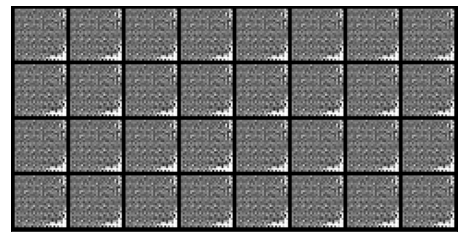

 71%|███████   | 71/100 [20:09<08:14, 17.04s/it]


Epoch [71/100], loss_g: 30.2102, loss_d: 0.0060


 72%|███████▏  | 72/100 [20:26<07:56, 17.03s/it]


Epoch [72/100], loss_g: 28.5766, loss_d: 0.0057


 73%|███████▎  | 73/100 [20:43<07:39, 17.02s/it]


Epoch [73/100], loss_g: 28.7547, loss_d: 0.0080


 74%|███████▍  | 74/100 [20:59<07:22, 17.01s/it]


Epoch [74/100], loss_g: 28.4629, loss_d: 0.0157

Epoch [75/100], loss_g: 16.9448, loss_d: 0.2652


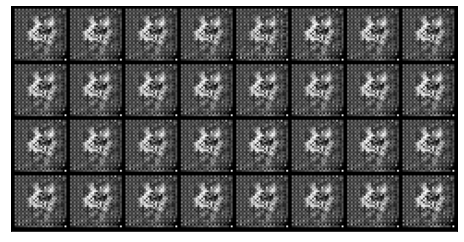

 76%|███████▌  | 76/100 [21:34<06:49, 17.07s/it]


Epoch [76/100], loss_g: 14.9532, loss_d: 0.2082


 77%|███████▋  | 77/100 [21:51<06:32, 17.06s/it]


Epoch [77/100], loss_g: 16.1119, loss_d: 0.1438


 78%|███████▊  | 78/100 [22:08<06:15, 17.06s/it]


Epoch [78/100], loss_g: 14.7739, loss_d: 0.1636


 79%|███████▉  | 79/100 [22:25<05:58, 17.06s/it]


Epoch [79/100], loss_g: 13.4827, loss_d: 0.4123

Epoch [80/100], loss_g: 12.0514, loss_d: 0.4575


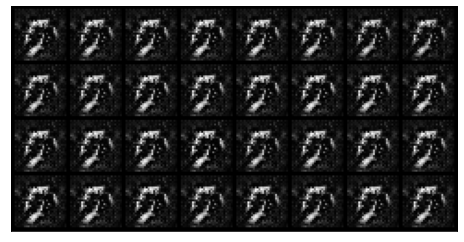

 81%|████████  | 81/100 [22:59<05:25, 17.13s/it]


Epoch [81/100], loss_g: 13.3472, loss_d: 0.3476


 82%|████████▏ | 82/100 [23:16<05:07, 17.08s/it]


Epoch [82/100], loss_g: 18.2891, loss_d: 0.1383


 83%|████████▎ | 83/100 [23:33<04:50, 17.08s/it]


Epoch [83/100], loss_g: 21.7895, loss_d: 0.0564


 84%|████████▍ | 84/100 [23:51<04:33, 17.09s/it]


Epoch [84/100], loss_g: 22.0238, loss_d: 0.0847

Epoch [85/100], loss_g: 24.6470, loss_d: 0.0488


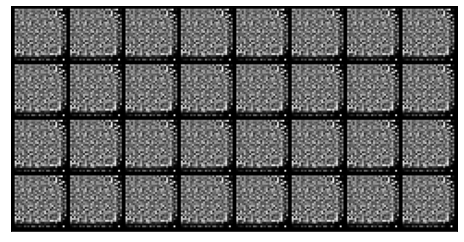

 86%|████████▌ | 86/100 [24:25<04:00, 17.15s/it]


Epoch [86/100], loss_g: 24.7482, loss_d: 0.0339


 87%|████████▋ | 87/100 [24:42<03:42, 17.08s/it]


Epoch [87/100], loss_g: 26.0161, loss_d: 0.0293


 88%|████████▊ | 88/100 [24:59<03:24, 17.07s/it]


Epoch [88/100], loss_g: 28.4384, loss_d: 0.0227


 89%|████████▉ | 89/100 [25:16<03:07, 17.04s/it]


Epoch [89/100], loss_g: 29.6739, loss_d: 0.0191

Epoch [90/100], loss_g: 30.0455, loss_d: 0.0122


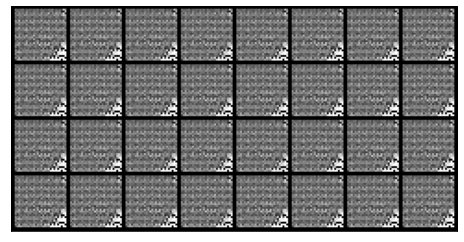

 91%|█████████ | 91/100 [25:50<02:33, 17.08s/it]


Epoch [91/100], loss_g: 29.6618, loss_d: 0.0136


 92%|█████████▏| 92/100 [26:07<02:16, 17.04s/it]


Epoch [92/100], loss_g: 28.7087, loss_d: 0.0054


 93%|█████████▎| 93/100 [26:24<01:59, 17.00s/it]


Epoch [93/100], loss_g: 28.3630, loss_d: 0.0043


 94%|█████████▍| 94/100 [26:41<01:41, 16.99s/it]


Epoch [94/100], loss_g: 30.3792, loss_d: 0.0058

Epoch [95/100], loss_g: 32.1113, loss_d: 0.0042


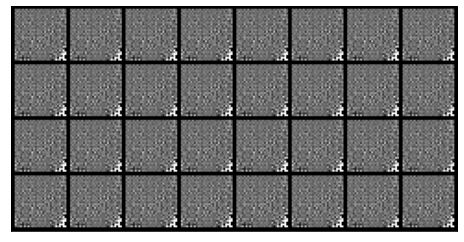

 96%|█████████▌| 96/100 [27:15<01:08, 17.06s/it]


Epoch [96/100], loss_g: 32.7228, loss_d: 0.0061


 97%|█████████▋| 97/100 [27:32<00:51, 17.04s/it]


Epoch [97/100], loss_g: 34.9833, loss_d: 0.0031


 98%|█████████▊| 98/100 [27:49<00:34, 17.05s/it]


Epoch [98/100], loss_g: 34.0518, loss_d: 0.0024


 99%|█████████▉| 99/100 [28:06<00:17, 17.03s/it]


Epoch [99/100], loss_g: 33.7631, loss_d: 0.0032

Epoch [100/100], loss_g: 36.0145, loss_d: 0.0029


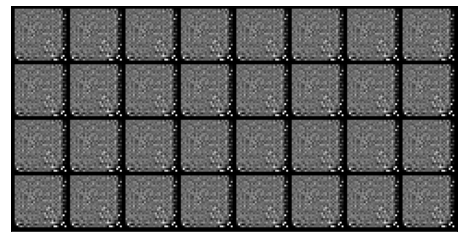

100%|██████████| 100/100 [28:23<00:00, 17.04s/it]


In [ ]:
def fit_net(gen_opt,dis_opt,criterion,loader,epoch):
    for i in tqdm(range(epoch)):
        Dis.train()
        Gen.train()
        print_gen_loss = print_dis_loss = .0
        #fake_score = real_score = .0
        for image, _ in loader:
            image = image.to(device)
            
            # train discriminator
            # fake image
            dis_opt.zero_grad()
            fake_image1 = Gen(get_noise())
            fake_predict = Dis(fake_image1.detach())
            fake_loss = criterion(fake_predict, torch.zeros_like(fake_predict))
            # real image
            real_predict = Dis(image)
            real_loss = criterion(real_predict, torch.ones_like(real_predict))
            disc_loss = (real_loss + fake_loss)/2
            disc_loss.backward()
            dis_opt.step()

            # train generator
            gen_opt.zero_grad()
            fake_image2 = Gen(get_noise())
            fake_predict = Dis(fake_image2)
            gen_loss = criterion(fake_predict,torch.ones_like(fake_predict))
            gen_loss.backward()
            gen_opt.step()

            print_dis_loss+=disc_loss.item()/len(image)
            print_gen_loss+=gen_loss.item()/len(image)

        print("\nEpoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            i+1, epoch, print_gen_loss, print_dis_loss))
            
        if (i+1)%5 == 0:
            Dis.eval()
            Gen.eval()
            noise = get_noise()
            fake_image = Gen(noise)
            fake_image = fake_image.detach().cpu()
            show_images(fake_image)

Dis = Dis.to(device)
Gen = Gen.to(device)
opt_d = torch.optim.Adam(Dis.parameters(), lr=0.0002,betas=(0.5,0.999))
opt_g = torch.optim.Adam(Gen.parameters(), lr=0.0002,betas=(0.5,0.999))
criterion = nn.BCEWithLogitsLoss()

fit_net(opt_g,opt_d,criterion,trainloader,100)